In [1]:
!pip install datasketch
!pip install reedsolo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 2.9 MB/s eta 0:00:00


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from datasketch import MinHash
import reedsolo
import hashlib
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.hashes import SHA256
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.backends import default_backend

In [3]:


dataset_path = "/kaggle/input/data-sets/74034_3_En_4_MOESM1_ESM/FVC2004/Dbs/DB2_B/"
print("Contents of dataset folder:", os.listdir(dataset_path))


Contents of dataset folder: ['106_4.tif', '106_3.tif', '106_6.tif', '105_5.tif', '105_4.tif', '105_7.tif', '109_7.tif', '109_1.tif', '107_6.tif', '103_6.tif', '107_3.tif', '108_7.tif', '104_5.tif', '108_5.tif', '108_2.tif', '102_3.tif', '107_7.tif', '109_3.tif', '105_6.tif', '101_7.tif', '103_7.tif', '102_8.tif', '108_6.tif', '106_1.tif', '101_2.tif', '105_2.tif', '104_2.tif', '105_1.tif', '103_1.tif', '102_7.tif', '109_6.tif', '106_7.tif', '109_2.tif', '108_3.tif', '104_8.tif', '101_4.tif', '106_2.tif', '107_2.tif', '102_5.tif', '106_5.tif', '101_8.tif', '102_6.tif', '109_5.tif', '101_5.tif', '110_6.tif', '107_1.tif', '102_4.tif', '107_5.tif', '103_5.tif', '104_4.tif', '109_4.tif', '104_6.tif', '110_4.tif', '107_8.tif', '108_8.tif', '104_3.tif', '101_1.tif', '105_8.tif', '110_3.tif', '110_7.tif', '110_2.tif', '110_5.tif', '103_4.tif', '106_8.tif', '103_3.tif', '101_3.tif', '101_6.tif', '107_4.tif', '110_1.tif', '109_8.tif', '102_1.tif', '103_2.tif', '105_3.tif', '103_8.tif', '102_2.ti

In [4]:
# Function to load fingerprint images
def load_images_from_folder(folder, img_size=(128, 128)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
        if img is not None:
            img = cv2.resize(img, img_size)  # Resize image to (128x128)
            images.append(img)
    return np.array(images)


In [5]:
# Load dataset
dataset_folder = "/kaggle/input/data-sets/74034_3_En_4_MOESM1_ESM/FVC2004/Dbs/DB2_B/"
X = load_images_from_folder(dataset_folder)
X = X.reshape(-1, 128, 128, 1)  # Reshape for CNN input
print(f"Loaded {len(X)} fingerprint images.")


Loaded 80 fingerprint images.


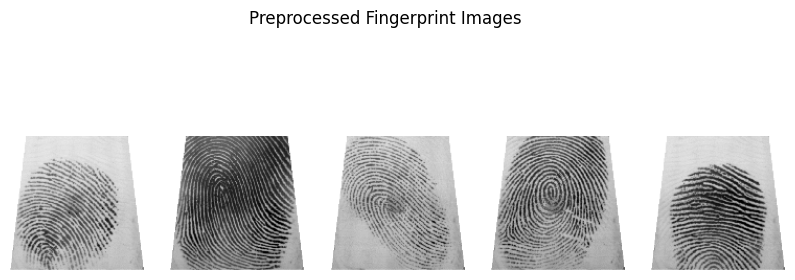

In [6]:
# Display sample images
if len(X) > 0:
    plt.figure(figsize=(10, 4))
    for i in range(min(5, len(X))):  
        plt.subplot(1, 5, i+1)
        plt.imshow(X[i].reshape(128, 128), cmap='gray')
        plt.axis('off')
    plt.suptitle("Preprocessed Fingerprint Images")
    plt.show()
else:
    print("Error: No images found in the dataset!")


In [7]:
# Define CNN Model with feature vector size = 64
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation='relu'),  # Feature extraction layer
    Dropout(0.5),

    Dense(64, activation='linear')  # Feature vector size changed to 64
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Display model summary
model.summary()

num_samples = X.shape[0]  
feature_vector_size = 64  

y = np.random.rand(num_samples, feature_vector_size)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,312,320 (12.64 MB)

 Trainable params: 3,312,320 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train CNN for 200 epochs
history = model.fit(X, y, batch_size=32, epochs=200, verbose=1)


Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 4019.4873 - mae: 41.6664
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 38.9757 - mae: 4.3427
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5354 - mae: 0.9130
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6421 - mae: 0.6397
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5854 - mae: 0.6163
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3363 - mae: 0.4910
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3299 - mae: 0.4964
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3268 - mae: 0.4869
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3218 - mae: 0.4801
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3173 - mae: 0.4759
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2941 - mae: 0.4451
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3203 - mae: 0.4860
Epoch 13/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/

In [9]:
# Function to extract a feature vector from an image
def extract_feature_vector(image):
    img = image.reshape(1, 128, 128, 1)  # Reshape for CNN input
    feature_vector = model.predict(img)
    return feature_vector.flatten()

# Example: Extract feature vector from the first fingerprint
sample_feature_vector = extract_feature_vector(X[0])
print("Extracted Feature Vector:", sample_feature_vector)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
Extracted Feature Vector: [0.4110357  0.51600343 0.48114473 0.3884832  0.51456356 0.49369302
 0.48367915 0.4624595  0.383201   0.4014137  0.45378444 0.44749245
 0.4788537  0.49079663 0.45236698 0.49958968 0.43042803 0.43215907
 0.5291969  0.3872608  0.49199018 0.46352124 0.43714762 0.45863178
 0.4927857  0.4764547  0.4409629  0.4390018  0.4709856  0.41407797
 0.510325   0.55887955 0.45786196 0.44258615 0.46203998 0.43655345
 0.4083907  0.39628726 0.5053594  0.46447018 0.46176562 0.48729807
 0.5068879  0.43972903 0.47161615 0.5020038  0.4858952  0.49994236
 0.43573737 0.41160625 0.44334045 0.3971662  0.45098498 0.49026188
 0.51664656 0.43586856 0.36830425 0.40379897 0.48278636 0.45932746
 0.43017763 0.5341176  0.51086444 0.4846532 ]


In [10]:
!pip install datasketch
!pip install reedsolo
!pip install cryptography

In [11]:
# Function to generate a stable key using fuzzy extraction
def generate_stable_key(feature_vector, num_hashes=128):
    """Generates a stable cryptographic key from fingerprint data using fuzzy extraction."""
    
    # Step 1: Convert fingerprint to MinHash digest
    minhash = MinHash(num_perm=num_hashes)
    for val in feature_vector:
        minhash.update(int(val).to_bytes(2, byteorder='big'))  # Ensure conversion to int before bytes
    
    minhash_digest = minhash.digest()
    
    # Step 2: Apply Reed-Solomon encoding (adds redundancy for error correction)
    rs = reedsolo.RSCodec(10)  # Adding 10 error correction bytes
    encoded_digest = rs.encode(minhash_digest)
    
    # Step 3: Generate a cryptographic key using SHA-256
    stable_key = hashlib.sha256(encoded_digest).hexdigest()
    
    return stable_key, encoded_digest

# Example: Extract feature vector from a fingerprint image
sample_feature_vector = extract_feature_vector(X[0])

# Generate stable key
stable_key, stored_encoded_minhash = generate_stable_key(sample_feature_vector)
print("Generated Stable Key:", stable_key)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Generated Stable Key: 117b1b5ecf7ce3dd0dca795302d5f8daacc864e422742ffc3c90a02a70658a25


In [12]:
#Convert Stable Key to ECC Private Key

def derive_ecc_key(stable_key):
    """Derives an ECC private key from the stable key using HKDF."""
    
    # Ensure stable_key is bytes (convert hex string to bytes)
    stable_key_bytes = bytes.fromhex(stable_key)  #Convert hex string to bytes

    # Use HKDF to derive a cryptographic key
    hkdf = HKDF(
        algorithm=hashes.SHA256(),
        length=32,  # ECC private keys are typically 32 bytes
        salt=None,
        info=b'fingerprint-derived-key',
        backend=default_backend()
    )
    
    private_key_bytes = hkdf.derive(stable_key_bytes)  # Now it's bytes
    
    # Convert to an ECC private key
    private_key = ec.derive_private_key(int.from_bytes(private_key_bytes, "big"), ec.SECP256R1(), default_backend())

    return private_key


In [13]:
def encrypt_message(message, public_key):
    shared_secret = public_key.public_numbers().x.to_bytes(32, 'big')  # ECDH shared secret

    # AES-GCM Encryption
    iv = os.urandom(12)
    cipher = Cipher(algorithms.AES(shared_secret), modes.GCM(iv))
    encryptor = cipher.encryptor()
    ciphertext = encryptor.update(message.encode()) + encryptor.finalize()
    
    return iv, ciphertext, encryptor.tag

def decrypt_message(iv, ciphertext, tag, private_key):
    shared_secret = private_key.public_key().public_numbers().x.to_bytes(32, 'big')  # ECDH shared secret

    # AES-GCM Decryption
    cipher = Cipher(algorithms.AES(shared_secret), modes.GCM(iv, tag))
    decryptor = cipher.decryptor()
    decrypted_message = decryptor.update(ciphertext) + decryptor.finalize()
    
    return decrypted_message.decode()

#Testing
if len(X) > 0:
    feature_vector = extract_feature_vector(X[0])  # Extract feature vector
    stable_key, encoded_digest = generate_stable_key(feature_vector)  # Generate stable key
    private_key = derive_ecc_key(stable_key)  # Convert stable key to ECC private key
    public_key = private_key.public_key()  # Get ECC public key
    
    # Test Encryption & Decryption
    original_message = "Secure Biometric Encryption"
    iv, ciphertext, tag = encrypt_message(original_message, public_key)
    decrypted_message = decrypt_message(iv, ciphertext, tag, private_key)

    print("\nGenerated Stable Key (SHA-256):", stable_key.hex() if isinstance(stable_key, bytes) else stable_key)
    print("\nECC Private Key:", private_key.private_numbers().private_value)
    print("\nOriginal Message:", original_message)
    print("\nEncrypted Ciphertext:", ciphertext.hex())
    print("\nDecrypted Message:", decrypted_message)

else:
    print("Error: No fingerprint images found!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Generated Stable Key (SHA-256): 117b1b5ecf7ce3dd0dca795302d5f8daacc864e422742ffc3c90a02a70658a25

ECC Private Key: 101424033646691196556206856324060542031991695985712986961885645282870766677362

Original Message: Secure Biometric Encryption

Encrypted Ciphertext: d11426a468b9af6d2d27b63c354bed03e3f3be3df94d103755c3f9

Decrypted Message: Secure Biometric Encryption
